# CNN

In [1]:
import pandas as pd
import numpy as np
import glob
import sys
sys.path.append('../src/')
from cnn_model import *
from evaluation_metrics import *
from utils import *
from matplotlib import pyplot as plt

In [2]:
#load processed data
directory = '../data/processed/'
titles = ['EUR_USD','USD_JPY','AUD_USD','GBP_USD','NZD_USD','USD_CAD','USD_CHF']

file_paths = {}
for title in titles:
    file_paths[title] = glob.glob(directory + f'{title.lower()}_*.npy')
# key to train/test set
xy_data = {}
for key, values in file_paths.items():
    s_val = sorted(values) # X_test, X_train, y_test, y_train
    xy_train_test = {}
    xy_train_test['X_test'] = np.load(s_val[0])
    xy_train_test['X_train'] = np.load(s_val[1])
    xy_train_test['y_test'] = np.load(s_val[2])
    xy_train_test['y_train'] = np.load(s_val[3])
    xy_data[key] = xy_train_test

#validation step
for key, val in xy_data.items():
    print(key)
    for x,y in val.items():
        print(f'{x}: {y.shape}')

EUR_USD
X_test: (14919, 30, 8)
X_train: (59673, 30, 8)
y_test: (14919,)
y_train: (59673,)
USD_JPY
X_test: (14919, 30, 8)
X_train: (59672, 30, 8)
y_test: (14919,)
y_train: (59672,)
AUD_USD
X_test: (14918, 30, 8)
X_train: (59668, 30, 8)
y_test: (14918,)
y_train: (59668,)
GBP_USD
X_test: (14919, 30, 8)
X_train: (59673, 30, 8)
y_test: (14919,)
y_train: (59673,)
NZD_USD
X_test: (14922, 30, 8)
X_train: (59684, 30, 8)
y_test: (14922,)
y_train: (59684,)
USD_CAD
X_test: (14917, 30, 8)
X_train: (59668, 30, 8)
y_test: (14917,)
y_train: (59668,)
USD_CHF
X_test: (14917, 30, 8)
X_train: (59668, 30, 8)
y_test: (14917,)
y_train: (59668,)


## Train Model

### Parameter setup
|Parameters| Value|
|----------|------|
|epochs|50|
|batch size|128|
|early stop patience|5|
|k-fold|5|

In [3]:
histories = {} #model history
cv_models = {} #trained models
log_loss = {}
#create and train cnn model for each pair
for count, (key, xy) in enumerate(xy_data.items()) :
    X_train = xy['X_train']
    y_train = xy['y_train']
    timestep = X_train.shape[1]
    features = X_train.shape[2]

    print(f"Training for {key}")
    model = create_cnn_model(timestep=timestep, features=features)
    history, mean_loss = cross_val(model=model, X=X_train, y=y_train)
    
    histories[key] = history
    cv_models[key] = model
    log_loss[key] = mean_loss
    print(f"Completed training: {count+1}/{len(key)}")
    print("\n")
print("Training complete")

Training for EUR_USD
Split 1, Train sample 11934, Val sample 11934
Epoch 1/50
94/94 [==============================] - 3s 6ms/step - loss: 0.9340 - accuracy: 0.4977 - val_loss: 0.7850 - val_accuracy: 0.4941
Epoch 2/50
94/94 [==============================] - 0s 4ms/step - loss: 0.7714 - accuracy: 0.5049 - val_loss: 0.7364 - val_accuracy: 0.4981
Epoch 3/50
94/94 [==============================] - 0s 4ms/step - loss: 0.7536 - accuracy: 0.5028 - val_loss: 0.7288 - val_accuracy: 0.4978
Epoch 4/50
94/94 [==============================] - 0s 4ms/step - loss: 0.7440 - accuracy: 0.5034 - val_loss: 0.7219 - val_accuracy: 0.4988
Epoch 5/50
94/94 [==============================] - 0s 5ms/step - loss: 0.7351 - accuracy: 0.5026 - val_loss: 0.7176 - val_accuracy: 0.5006
Epoch 6/50
94/94 [==============================] - 0s 5ms/step - loss: 0.7301 - accuracy: 0.5018 - val_loss: 0.7141 - val_accuracy: 0.4984
Epoch 7/50
94/94 [==============================] - 0s 5ms/step - loss: 0.7266 - accuracy: 0.

# Cross Validation Evaluation

### Accuracy score over splits
-  A high accuracy with low variance across splits indicates good generalization
-  High variability indicates high dependence on specific training data, likely due to noise

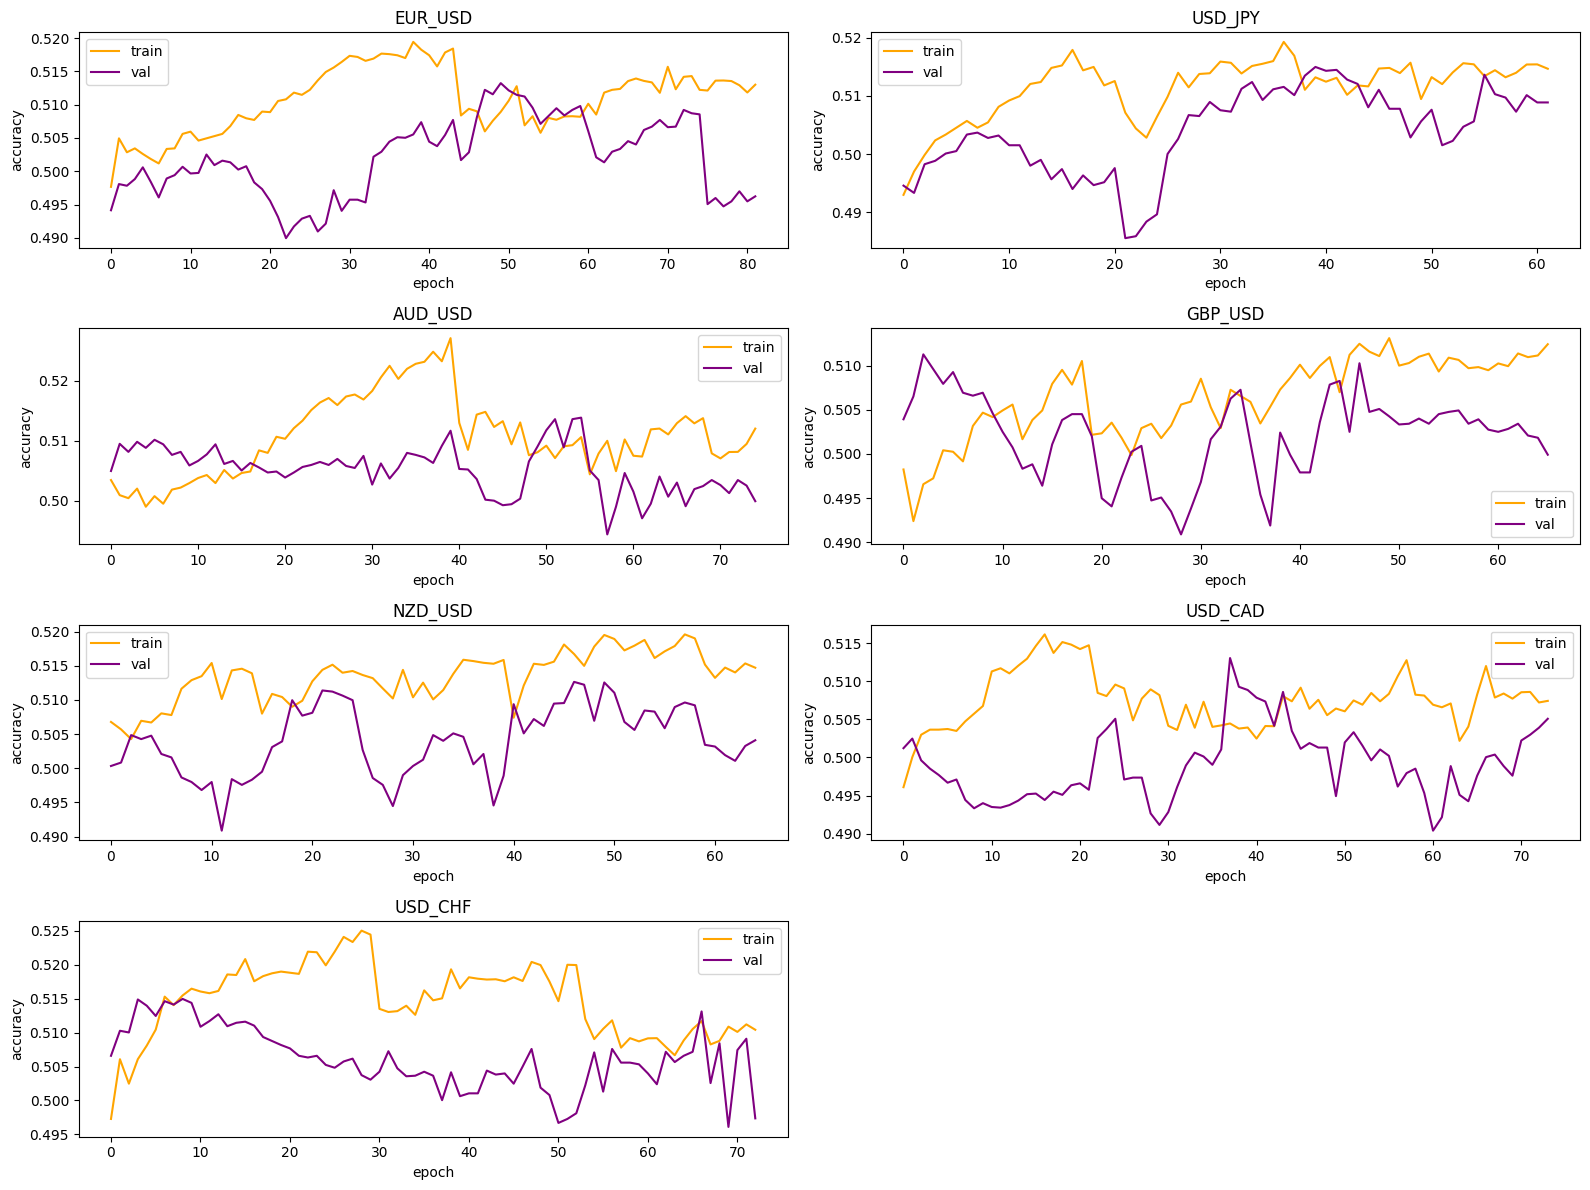

In [4]:
plt.figure(figsize=(16, 12))

for pos, (title, history_list) in enumerate(histories.items()):
    accuracy = []
    val_accuracy = []
    for history in history_list:
        accuracy.extend(history.history['accuracy'])
        val_accuracy.extend(history.history['val_accuracy'])
    plt.subplot(4,2,pos+1)
    plt.plot(accuracy, color='orange',label='train' )
    plt.plot(val_accuracy, color='purple', label='val' )
    plt.title(title)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
plt.tight_layout()
plt.show()

### Mean Accuracy

split1 mean train, val: 0.5173877477645874, 0.5026636251381466
split2 mean train, val: 0.5121802687644958, 0.5019092389515468
split3 mean train, val: 0.5133491669382367, 0.5055123780454908
split4 mean train, val: 0.5121082663536072, 0.5016458800860814


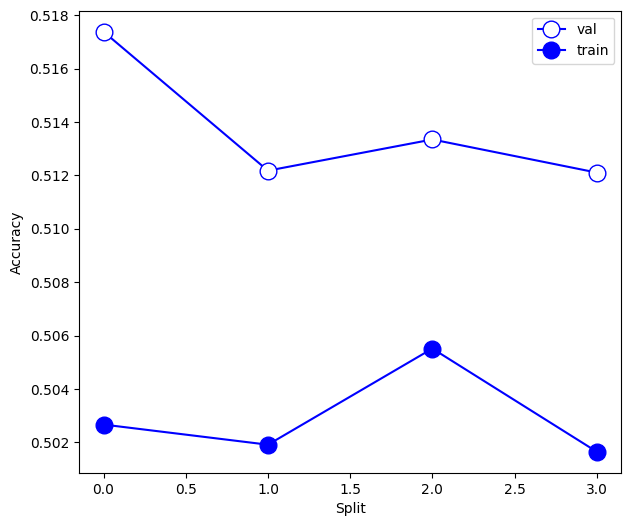

In [22]:
plt.figure(figsize=(7, 6))

splits = []
mean_train_acc = []
mean_val_acc = []



for pos, (title, history_list) in enumerate(histories.items()):
    count = len(history_list)
    for history in history_list:
        splits.append([history.history['accuracy'][-1], history.history['val_accuracy'][-1]])

for i in range(0,count):
    sum_val = 0
    sum_train = 0
    for j in range(i,(count*len(title)),4): #acc,val for each split 1-4
        sum_train = sum_train + splits[j][0]
        sum_val = sum_val + splits[j][1]
    mean_sum_val = sum_val/len(title)
    mean_sum_train = sum_train/len(title)
    print(f'split{i+1} mean train, val: {mean_sum_train}, {mean_sum_val}')
    mean_train_acc.append(mean_sum_train)
    mean_val_acc.append(mean_sum_val)
    
plt.plot(mean_train_acc, label='val', color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
plt.plot(mean_val_acc, label='train', color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='blue')
plt.xlabel('Split')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Mean Loss

In [5]:
np.mean(np.array(list(log_loss.values())))

0.6967755895612832

split1 mean train, val: 0.699481087071555, 0.7040520140102932
split2 mean train, val: 0.6970521977969578, 0.7002012389046806
split3 mean train, val: 0.6927717157772609, 0.6948375020708356
split4 mean train, val: 0.6926691106387547, 0.693859875202179


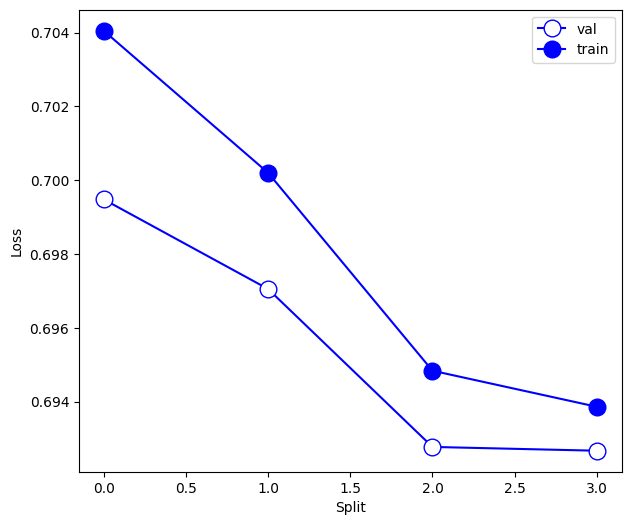

In [23]:
plt.figure(figsize=(7, 6))

splits = []
mean_train_acc = []
mean_val_acc = []



for pos, (title, history_list) in enumerate(histories.items()):
    count = len(history_list)
    for history in history_list:
        splits.append([history.history['loss'][-1], history.history['val_loss'][-1]])

for i in range(0,count):
    sum_val = 0
    sum_train = 0
    for j in range(i,(count*len(title)),4): #acc,val for each split 1-4
        sum_train = sum_train + splits[j][0]
        sum_val = sum_val + splits[j][1]
    mean_sum_val = sum_val/len(title)
    mean_sum_train = sum_train/len(title)
    print(f'split{i+1} mean train, val: {mean_sum_train}, {mean_sum_val}')
    mean_train_acc.append(mean_sum_train)
    mean_val_acc.append(mean_sum_val)
    
plt.plot(mean_train_acc, label='val', color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='white')
plt.plot(mean_val_acc, label='train', color='b', marker='.', linestyle='solid', markersize=24, markerfacecolor='blue')
plt.xlabel('Split')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Loss analysis

Detects for overfitting and underfitting
- Overfitting: Train loss is significantly lower than validation loss
- Underfitting: Train loss and validation loss is both high
- Ideal: Train loss and val loss are equally low"

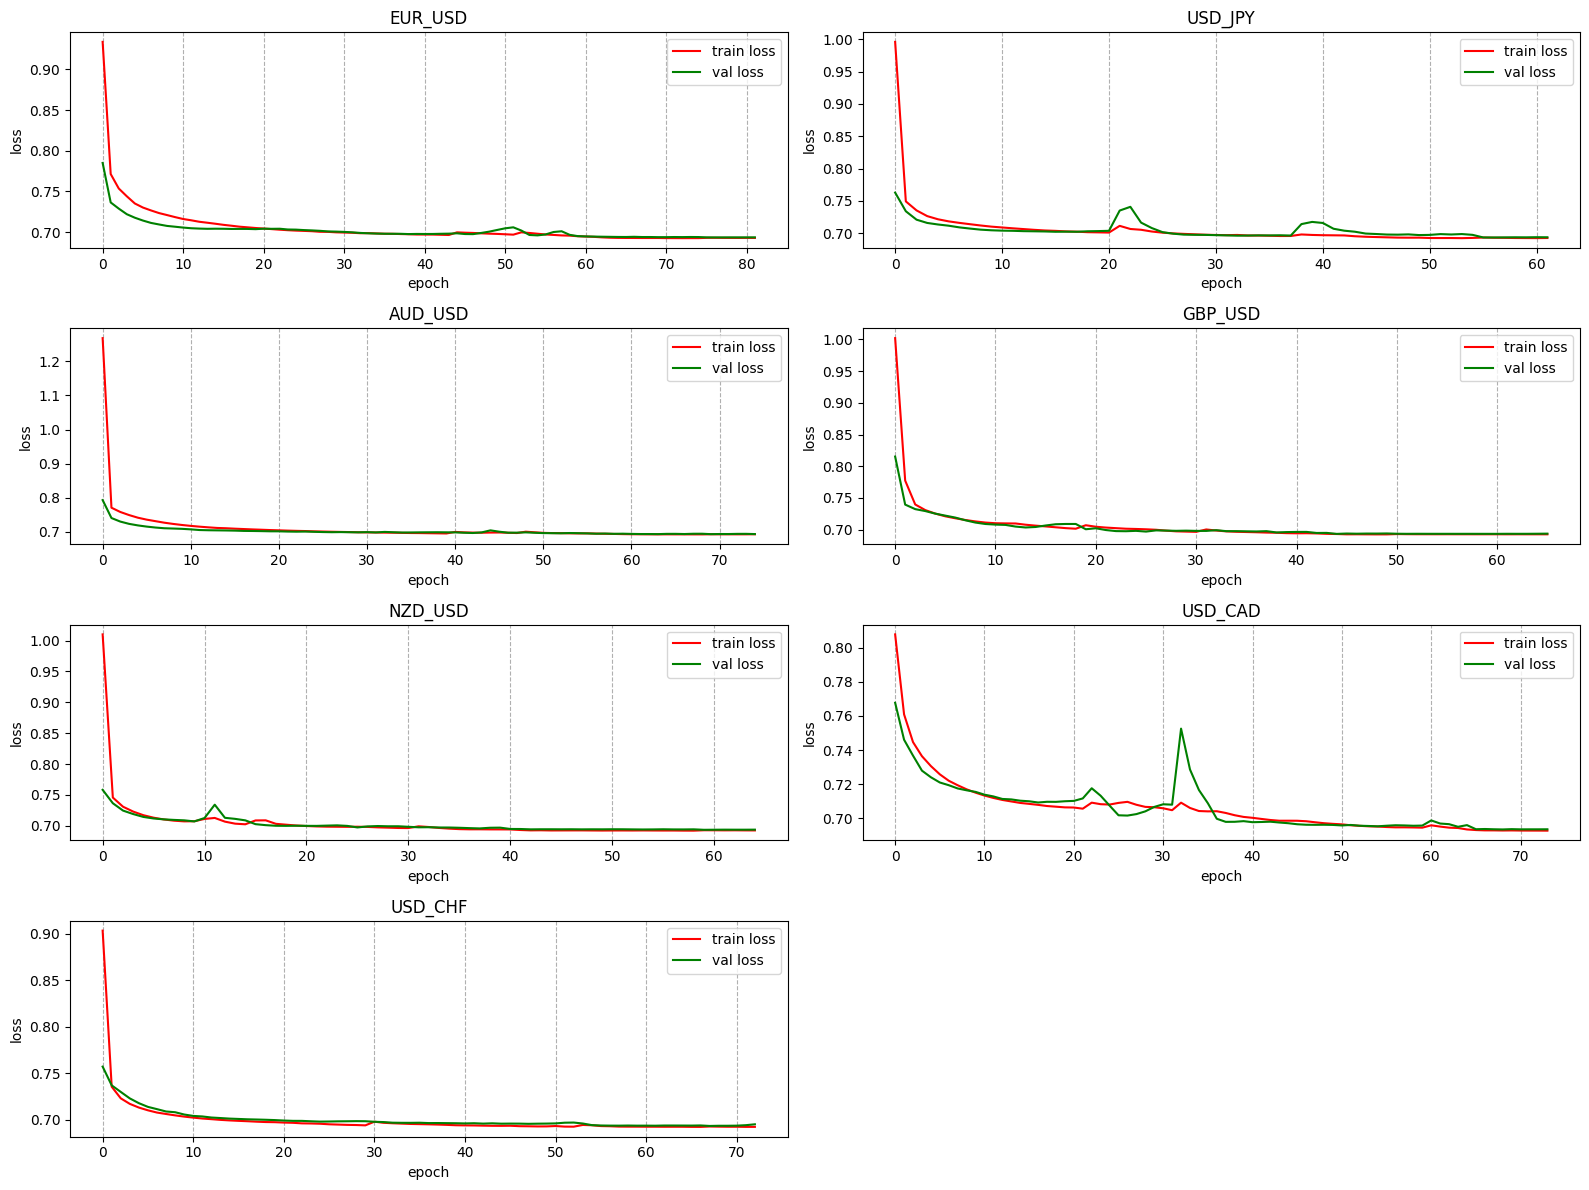

In [6]:
#train loss

plt.figure(figsize=(16, 12))

for pos, (title, history_list) in enumerate(histories.items()):
    train_losses = []
    val_losses = []
    for history in history_list:
        train_losses.extend(history.history['loss'])
        val_losses.extend(history.history['val_loss'])
    plt.subplot(4,2,pos+1)
    plt.plot(train_losses, label='train loss', color='red')
    plt.plot(val_losses, label='val loss', color='green')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(axis='x', linestyle='--')
    plt.title(title)
plt.tight_layout()
plt.show()

## Model Summary

In [7]:
cv_models['EUR_USD'].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 27, 32)            1056      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 416)               0         
                                                                 
 dense (Dense)               (None, 1)                 417       
                                                                 
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [8]:
models = {}
for (key, model), xy in zip(cv_models.items(), xy_data.values()):
    history = train_model(model, xy['X_train'], xy['y_train'])
    models[key] = model

Epoch 1/50
467/467 [==============================] - 1s 3ms/step - loss: 0.6930 - accuracy: 0.5081
Epoch 2/50
467/467 [==============================] - 1s 3ms/step - loss: 0.6929 - accuracy: 0.5089
Epoch 3/50
467/467 [==============================] - 1s 3ms/step - loss: 0.6929 - accuracy: 0.5075
Epoch 4/50
467/467 [==============================] - 1s 3ms/step - loss: 0.6929 - accuracy: 0.5065
Epoch 5/50
467/467 [==============================] - 1s 3ms/step - loss: 0.6929 - accuracy: 0.5088
Epoch 6/50
467/467 [==============================] - 1s 3ms/step - loss: 0.6929 - accuracy: 0.5086
Epoch 7/50
467/467 [==============================] - 1s 3ms/step - loss: 0.6928 - accuracy: 0.5090
Epoch 8/50
467/467 [==============================] - 1s 3ms/step - loss: 0.6928 - accuracy: 0.5087
Epoch 9/50
467/467 [==============================] - 1s 3ms/step - loss: 0.6928 - accuracy: 0.5100
Epoch 10/50
467/467 [==============================] - 1s 3ms/step - loss: 0.6928 - accuracy: 0.5083

# Model Evaluation

### Generate test prediction

In [9]:
threshold = 0.5
y_pred_dict = {}
y_pred_dict_prob = {}
for (key, model), xy in zip(models.items(), xy_data.values() ):
    y_pred = model.predict(xy['X_test'])
    y_pred_dict_prob[key] = y_pred
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_pred_binary = y_pred_binary.flatten() #Convert to 1D
    y_pred_dict[key] = y_pred_binary
    print(key)
    print(np.bincount(y_train))  # Count occurrences of each class in the training set
    print(np.bincount(xy['y_test']))   # testing set
    print(np.bincount(y_pred_binary)) # prediction set
    print(len(xy['y_test'])-len(y_pred_binary))
    print(len)

467/467 [==============================] - 1s 1ms/step
EUR_USD
[30040 29628]
[7506 7413]
[14432   487]
0
<built-in function len>
467/467 [==============================] - 0s 902us/step
USD_JPY
[30040 29628]
[7340 7579]
[ 2525 12394]
0
<built-in function len>
467/467 [==============================] - 1s 1ms/step
AUD_USD
[30040 29628]
[7516 7402]
[8574 6344]
0
<built-in function len>
467/467 [==============================] - 0s 909us/step
GBP_USD
[30040 29628]
[7471 7448]
[13713  1206]
0
<built-in function len>
467/467 [==============================] - 1s 1ms/step
NZD_USD
[30040 29628]
[7628 7294]
[14076   846]
0
<built-in function len>
467/467 [==============================] - 1s 1ms/step
USD_CAD
[30040 29628]
[7560 7357]
[13579  1338]
0
<built-in function len>
467/467 [==============================] - 1s 1ms/step
USD_CHF
[30040 29628]
[7507 7410]
[13891  1026]
0
<built-in function len>


#### Visualization of y_test and y_pred

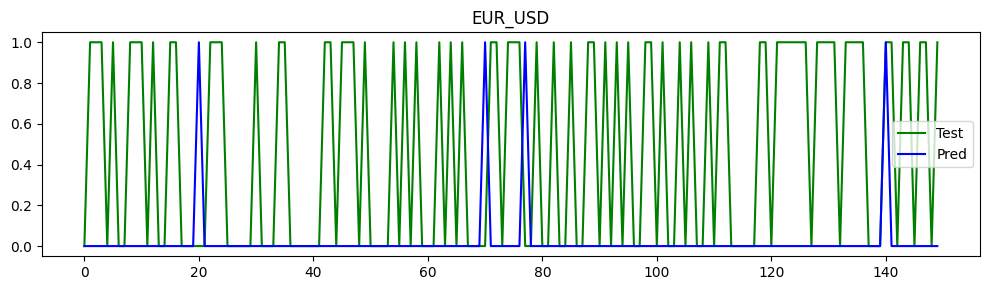

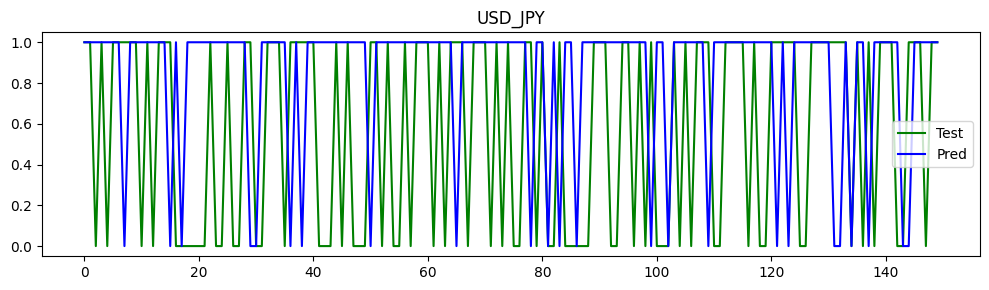

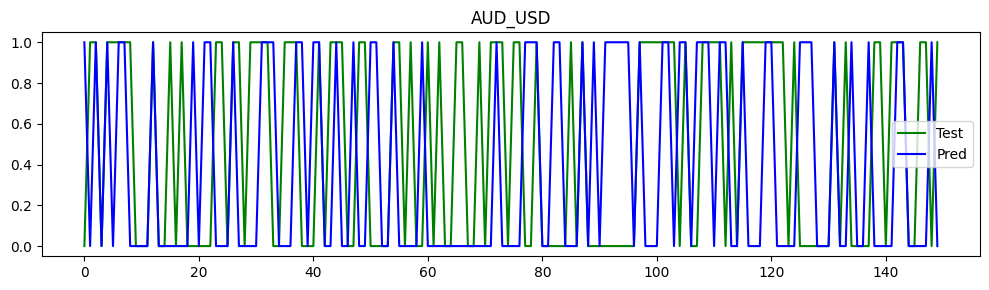

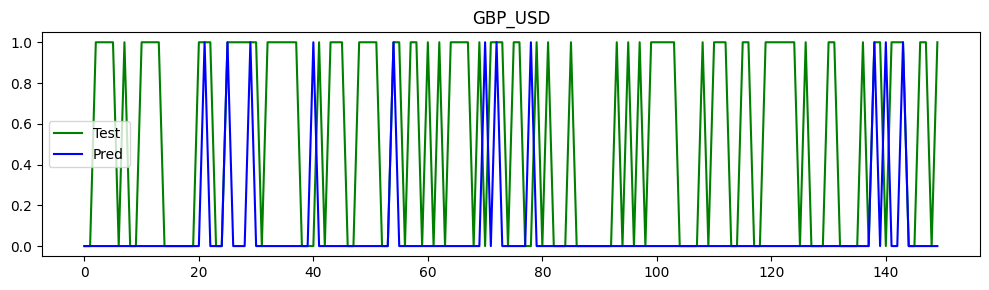

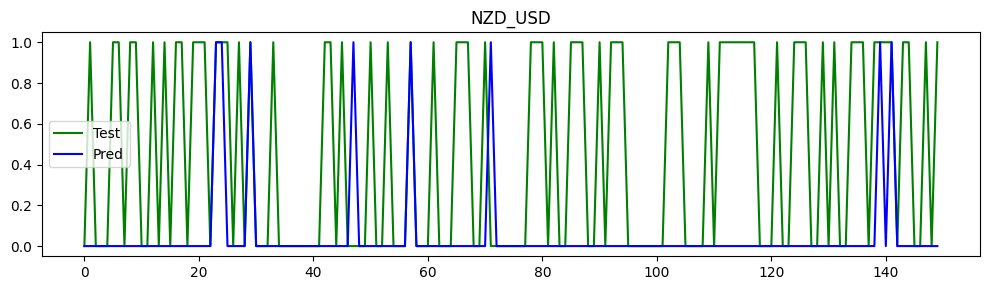

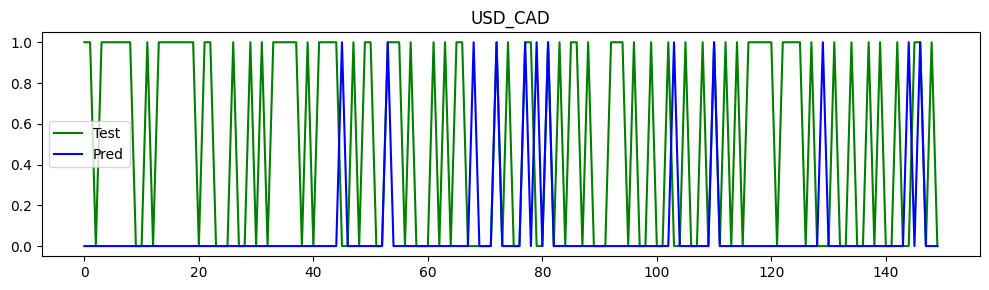

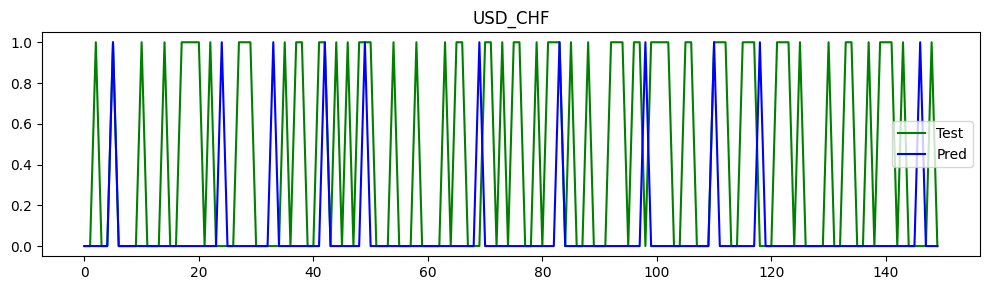

In [10]:
for pos, ((key, y_pred), xy) in enumerate(zip(y_pred_dict.items(),xy_data.values())):  
    step = 100 
    y_test_ds = xy['y_test'][::step] #downsampled to 100 steps
    y_pred_ds = y_pred[::step]

    #plt.subplot(7,1,pos+1)
    plt.figure(figsize=(10,3))
    plt.plot(y_test_ds, color = "green", label = "Test")
    plt.plot(y_pred_ds, color = "blue", label = "Pred")
    plt.title(key)
    plt.tight_layout()
    plt.legend()

plt.show()

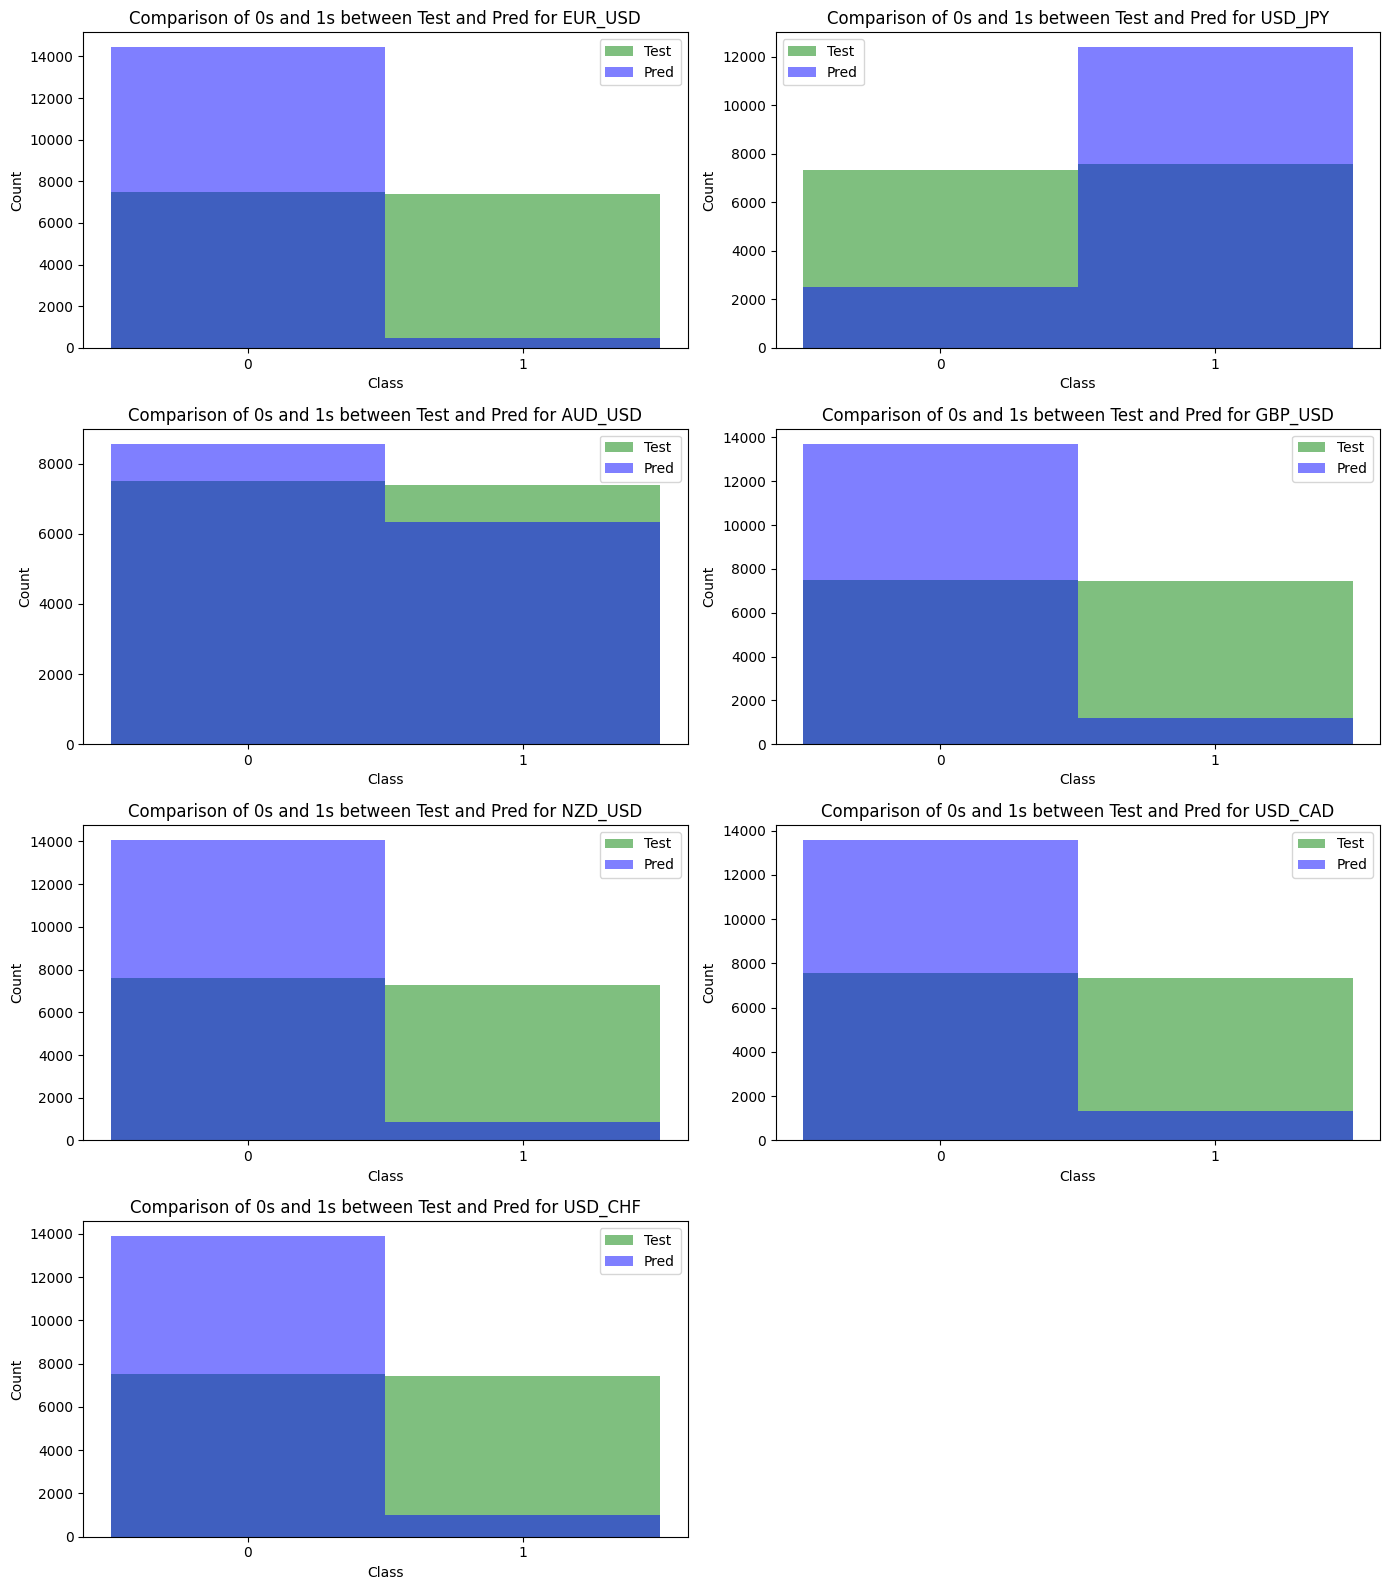

In [11]:
plt.figure(figsize=(14, 16))

for pos, ((key, y_pred), xy) in enumerate (zip(y_pred_dict.items(), xy_data.values())):
    test_counts = np.bincount(xy['y_test'])
    pred_counts = np.bincount(y_pred)

    # Plotting histograms using plt directly
    plt.subplot(4,2,pos+1)
    # Plot test data histogram
    plt.hist(xy['y_test'], bins=[-0.5, 0.5, 1.5], alpha=0.5, color='green', label='Test')

    # Plot pred data histogram
    plt.hist(y_pred, bins=[-0.5, 0.5, 1.5], alpha=0.5, color='blue', label='Pred')

    # Customize plot
    plt.xticks([0, 1], ['0', '1'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Comparison of 0s and 1s between Test and Pred for {key}')
    plt.tight_layout()
    plt.legend()
    

plt.show()


## Metrics

Evaluate performance with accuracy, f1_score, precision and recall

In [12]:
metrics_dict = {}

for xy, (key, y_pred) in zip(xy_data.values(), y_pred_dict.items()):
    
    metrics = calculate_metrics(xy['y_test'], y_pred)
    metrics_dict[key] = metrics
    print(f"{key}: ", metrics)

EUR_USD:  {'accuracy': 0.5017092298411422, 'f1_score': 0.0589873417721519, 'precision': 0.4784394250513347, 'recall': 0.03143126939160933}
USD_JPY:  {'accuracy': 0.5041892888263289, 'f1_score': 0.6296500275371751, 'precision': 0.507342262385025, 'recall': 0.8296609051326033}
AUD_USD:  {'accuracy': 0.49376592036466016, 'f1_score': 0.4506038120180416, 'precision': 0.48817780580075665, 'recall': 0.4184004323155904}
GBP_USD:  {'accuracy': 0.5049266036597627, 'f1_score': 0.14652183961174023, 'precision': 0.5257048092868989, 'recall': 0.08512352309344791}
NZD_USD:  {'accuracy': 0.5113255595764643, 'f1_score': 0.10417690417690417, 'precision': 0.5011820330969267, 'recall': 0.058129969838223196}
USD_CAD:  {'accuracy': 0.49969833076355835, 'f1_score': 0.14169062679700978, 'precision': 0.46038863976083705, 'recall': 0.08372978116079924}
USD_CHF:  {'accuracy': 0.5055306026680968, 'f1_score': 0.12565196775723092, 'precision': 0.5165692007797271, 'recall': 0.07152496626180836}


##### Metric Bar Chart

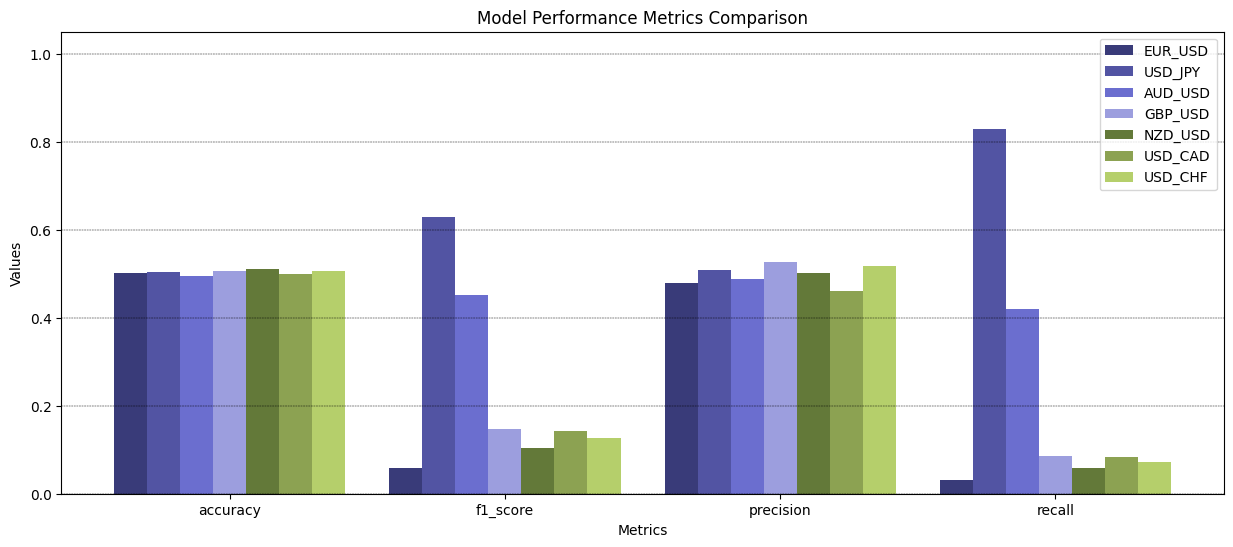

In [13]:
all_metrics = list(next(iter(metrics_dict.values())).keys())

num_models = len(metrics_dict)
bar_width = 0.12
index = np.arange(len(all_metrics))

plt.figure(figsize=(15, 6))
colors = plt.get_cmap('tab20b').colors

for i, (key, metrics) in enumerate(metrics_dict.items()):
    values = [metrics[metric] for metric in all_metrics]
    plt.bar(index + i * bar_width, values, bar_width, label=key, color=colors[i])
    
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Metrics Comparison')
plt.xticks(index + bar_width * (num_models - 1) / 2, all_metrics)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, axis='y', linestyle='--', linewidth=0.35, color='black')

plt.show()

#### Reciever Operating Characteristic Curve

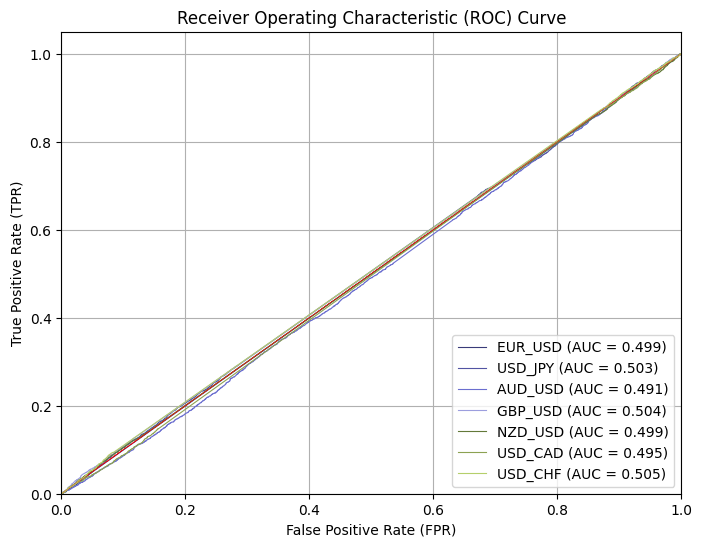

In [14]:
from sklearn.metrics import roc_curve, auc
y_probs = xy_data.items()
y_pred_dict_prob

plt.figure(figsize=(8, 6))
for i, ((key, xy), y_prob) in enumerate(zip(xy_data.items(), y_pred_dict_prob.values())):
    fpr, tpr, thresholds = roc_curve(xy['y_test'], y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=0.8, label=f'{key} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
plt.show()

##### Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix

for (title, y_pred), xy in zip(y_pred_dict.items(), xy_data.values()):
    print(title)
    cm = confusion_matrix(xy['y_test'], y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f'True Negatives: {tn}, False Positives: {fp}, False Negatives: {fn}, True Positives: {tp}')

EUR_USD
True Negatives: 7252, False Positives: 254, False Negatives: 7180, True Positives: 233
USD_JPY
True Negatives: 1234, False Positives: 6106, False Negatives: 1291, True Positives: 6288
AUD_USD
True Negatives: 4269, False Positives: 3247, False Negatives: 4305, True Positives: 3097
GBP_USD
True Negatives: 6899, False Positives: 572, False Negatives: 6814, True Positives: 634
NZD_USD
True Negatives: 7206, False Positives: 422, False Negatives: 6870, True Positives: 424
USD_CAD
True Negatives: 6838, False Positives: 722, False Negatives: 6741, True Positives: 616
USD_CHF
True Negatives: 7011, False Positives: 496, False Negatives: 6880, True Positives: 530


## Save results 

In [24]:
#Save results to csv
model_type = 'CNN'

for key, metrics in metrics_dict.items():
    metrics_df = pd.DataFrame([metrics])
    save_metrics_to_csv(metrics_df, model_type, f'{key}')

End of Section